# Grocery shelf Segmentation Using Computer Vision

Retail Inventory Management: This project enables accurate detection and segmentation of products on shelves, aiding in inventory tracking, stock level analysis, and ensuring planogram compliance.

Automation in Retail Insights: It reduces manual effort by automating the identification of product placements, improving efficiency in monitoring store layouts and enhancing customer experience.

# Step 1: Set Up Environment

In [ ]:
!pip install torch matplotlib opencv-python-headless pytesseract
!sudo apt-get install tesseract-ocr

!pip install torchvision==0.15.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,582 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

# Step 2: Prepare Dataset.

In [ ]:
import os
import pandas as pd

# Step 1: Download and extract SKU110K dataset
!gdown --id 1iq93lCdhaPUN0fWbLieMtzfB1850pKwd -O ./SKU110K.zip
!mkdir -p ./data/sku110k/
!tar -xvzf SKU110K.zip -C ./data/sku110k/.

# Step 2: Load and validate annotations
annotations_path = './data/sku110k/SKU110K_fixed/annotations/annotations_train.csv'

# Ensure the file exists
if not os.path.exists(annotations_path):
    raise FileNotFoundError(f"Annotations file not found: {annotations_path}")

# Load annotations with appropriate column names
columns = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'class', 'width', 'height']
annotations = pd.read_csv(annotations_path, names=columns)

# Step 3: Filter invalid bounding boxes
annotations['x_min'] = annotations['x_min'].clip(lower=0, upper=annotations['width'])
annotations['y_min'] = annotations['y_min'].clip(lower=0, upper=annotations['height'])
annotations['x_max'] = annotations['x_max'].clip(lower=0, upper=annotations['width'])
annotations['y_max'] = annotations['y_max'].clip(lower=0, upper=annotations['height'])
annotations = annotations[(annotations['x_min'] < annotations['x_max']) & (annotations['y_min'] < annotations['y_max'])]

# Step 4: Create a smaller subset of images
subset_images = annotations['image_id'].unique()[:50]  # Use only 50 images for smaller dataset
annotations_filtered = annotations[annotations['image_id'].isin(subset_images)]

# Save filtered annotations
filtered_annotations_path = './data/sku110k/SKU110K_fixed/annotations_filtered.csv'
annotations_filtered.to_csv(filtered_annotations_path, index=False)

print(f"Subset size: {len(subset_images)} images.")
print(f"Filtered annotations saved to: {filtered_annotations_path}")


Streaming output truncated to the last 5000 lines.
SKU110K_fixed/images/train_268.jpg
SKU110K_fixed/images/test_2667.jpg
SKU110K_fixed/images/val_510.jpg
SKU110K_fixed/images/val_5.jpg
SKU110K_fixed/images/train_2623.jpg
SKU110K_fixed/images/train_2118.jpg
SKU110K_fixed/images/test_1188.jpg
SKU110K_fixed/images/train_1523.jpg
SKU110K_fixed/images/test_2256.jpg
SKU110K_fixed/images/test_1661.jpg
SKU110K_fixed/images/train_330.jpg
SKU110K_fixed/images/test_789.jpg
SKU110K_fixed/images/train_1112.jpg
SKU110K_fixed/images/train_399.jpg
SKU110K_fixed/images/test_2798.jpg
SKU110K_fixed/images/test_1250.jpg
SKU110K_fixed/images/train_7892.jpg
SKU110K_fixed/images/test_378.jpg
SKU110K_fixed/images/train_7387.jpg
SKU110K_fixed/images/test_5.jpg
SKU110K_fixed/images/train_6381.jpg
SKU110K_fixed/images/test_851.jpg
SKU110K_fixed/images/test_1792.jpg
SKU110K_fixed/images/train_7481.jpg
SKU110K_fixed/images/train_4828.jpg
SKU110K_fixed/images/val_168.jpg
SKU110K_fixed/images/train_8044.jpg
SKU110K_

#Step 3: Define Dataset Loader.

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
import os
from PIL import Image
import pandas as pd
import numpy as np


class SKU110KSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotations_file, transforms=None):
        self.root = os.path.join(root, "images")
        self.transforms = transforms
        self.annotations = pd.read_csv(annotations_file)
        self.imgs = sorted(self.annotations['image_id'].unique())

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")

        records = self.annotations[self.annotations['image_id'] == img_name]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values.tolist()
        labels = [1] * len(boxes)  # Assuming a single object class

        # Generate binary masks for each bounding box
        width, height = img.size
        masks = np.zeros((len(boxes), height, width), dtype=np.uint8)
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = map(int, box)
            masks[i, y_min:y_max, x_min:x_max] = 1

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "masks": torch.as_tensor(masks, dtype=torch.uint8)  # Add masks
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


# Define the transforms
def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])


# Dataset and DataLoader
root_dir = './data/sku110k/SKU110K_fixed'
annotations_file = os.path.join(root_dir, "annotations_filtered.csv")
dataset = SKU110KSegmentationDataset(root_dir, annotations_file, transforms=get_transform())
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
for imgs, targets in data_loader:
    print(f"Image shape: {imgs[0].shape}")
    print(f"Target keys: {targets[0].keys()}")
    print(f"Sample masks shape: {targets[0]['masks'].shape}")
    break


Image shape: torch.Size([3, 2560, 1920])
Target keys: dict_keys(['boxes', 'labels', 'masks'])
Sample masks shape: torch.Size([141, 2560, 1920])


# Step 5: Fine-Tune the Object Detection Model

In [ ]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


PyTorch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [ ]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [ ]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader

# Step 1: Define transformations
def get_transform():
    return Compose([
        Resize((512, 512)),  # Resize images to 512x512
        ToTensor()
    ])

# Step 2: Initialize the Mask R-CNN model
model = maskrcnn_resnet50_fpn(weights="DEFAULT")

# Modify the model for the dataset (1 class + background)
num_classes = 2  # 1 object class (e.g., "object") + background

# Update the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Update the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Step 3: Move model to the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Step 4: Define optimizer and learning rate scheduler
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Step 5: Initialize dataset and data loader (assuming dataset is already prepared)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Step 6: Use mixed precision training
scaler = GradScaler()
num_epochs = 1  # Adjust as needed

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (imgs, targets) in enumerate(data_loader):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        try:
            with autocast():
                loss_dict = model(imgs, targets)
                losses = sum(loss for loss in loss_dict.values())

            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += losses.item()
            print(f"Processed batch {batch_idx + 1}/{len(data_loader)} - Loss: {losses.item():.4f}")
        except Exception as e:
            print(f"Error processing batch {batch_idx + 1}: {e}")

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss:.4f}")

print("Training Complete!")


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 148MB/s]


Starting Training...
Processed batch 1/50 - Loss: 5.0505
Processed batch 2/50 - Loss: 5.6567
Processed batch 3/50 - Loss: 4.3252
Processed batch 4/50 - Loss: 1.9134
Processed batch 5/50 - Loss: 2.6359
Processed batch 6/50 - Loss: 2.3925
Processed batch 7/50 - Loss: 1.8743
Processed batch 8/50 - Loss: 2.0730
Processed batch 9/50 - Loss: 2.3272
Processed batch 10/50 - Loss: 2.8327
Processed batch 11/50 - Loss: 2.0394
Processed batch 12/50 - Loss: 1.7751
Processed batch 13/50 - Loss: 2.0118
Processed batch 14/50 - Loss: 1.6392
Processed batch 15/50 - Loss: 1.6586
Processed batch 16/50 - Loss: 1.6337
Processed batch 17/50 - Loss: 2.3757
Processed batch 18/50 - Loss: 1.3865
Processed batch 19/50 - Loss: 1.6054
Processed batch 20/50 - Loss: 2.1182
Processed batch 21/50 - Loss: 1.5658
Processed batch 22/50 - Loss: 1.8669
Processed batch 23/50 - Loss: 1.6659
Processed batch 24/50 - Loss: 1.4119
Processed batch 25/50 - Loss: 1.9441
Processed batch 26/50 - Loss: 1.3391
Processed batch 27/50 - Lo

In [ ]:
# Save the partially trained model
model_save_path = "mask_rcnn_sku110k_partial.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Partially trained model saved at {model_save_path}.")


Partially trained model saved at mask_rcnn_sku110k_partial.pth.


In [ ]:
# Reload the saved model
model = maskrcnn_resnet50_fpn(weights=None)  # Initialize model with no pre-trained weights
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
model.load_state_dict(torch.load("mask_rcnn_sku110k_partial.pth"))
model.to(device)
model.eval()  # Set to evaluation mode
print("Model loaded successfully.")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Model loaded successfully.


In [ ]:
from torch.utils.data import random_split, DataLoader

# Split the dataset into training and validation
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
_, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Evaluate on validation data
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)
        for i, output in enumerate(outputs):
            print(f"Image {i+1}:")
            print(f"Predicted Boxes: {output['boxes']}")
            print(f"Scores: {output['scores']}")
            print(f"Labels: {output['labels']}")
        break  # Print for one batch


Image 1:
Predicted Boxes: tensor([[1484.1316, 2005.0334, 1594.3499, 2268.9216],
        [ 803.0264, 1954.4302,  924.9122, 2270.6602],
        [1090.1593, 2400.4636, 1201.1201, 2666.3237],
        [1741.0608, 2457.0044, 1850.1746, 2684.8879],
        [ 873.7939, 1136.3079,  979.8765, 1386.9360],
        [1085.9398, 2024.6031, 1198.6641, 2269.7139],
        [1348.2673, 2024.3234, 1468.6874, 2268.6394],
        [1358.9268, 1106.6696, 1469.4716, 1388.2175],
        [1029.3601, 1580.8197, 1144.8065, 1816.3196],
        [1520.6573, 2825.9465, 1586.2971, 3083.6072],
        [1647.3687, 1583.5566, 1768.7701, 1826.0652],
        [ 753.2550, 1576.1323,  869.2648, 1825.5525],
        [ 614.7937, 1087.5073,  728.9018, 1366.9099],
        [1853.9882, 2482.4160, 1973.3085, 2677.8630],
        [ 957.7593, 2022.5773, 1069.0045, 2265.7002],
        [ 589.9095, 1564.7738,  720.9392, 1827.3143],
        [1787.4615, 1580.2629, 1883.4822, 1837.2908],
        [1889.9935, 1603.2623, 1996.4396, 1848.0109],
  

In [ ]:
outputs

[{'boxes': tensor([[1484.1316, 2005.0334, 1594.3499, 2268.9216],
          [ 803.0264, 1954.4302,  924.9122, 2270.6602],
          [1090.1593, 2400.4636, 1201.1201, 2666.3237],
          [1741.0608, 2457.0044, 1850.1746, 2684.8879],
          [ 873.7939, 1136.3079,  979.8765, 1386.9360],
          [1085.9398, 2024.6031, 1198.6641, 2269.7139],
          [1348.2673, 2024.3234, 1468.6874, 2268.6394],
          [1358.9268, 1106.6696, 1469.4716, 1388.2175],
          [1029.3601, 1580.8197, 1144.8065, 1816.3196],
          [1520.6573, 2825.9465, 1586.2971, 3083.6072],
          [1647.3687, 1583.5566, 1768.7701, 1826.0652],
          [ 753.2550, 1576.1323,  869.2648, 1825.5525],
          [ 614.7937, 1087.5073,  728.9018, 1366.9099],
          [1853.9882, 2482.4160, 1973.3085, 2677.8630],
          [ 957.7593, 2022.5773, 1069.0045, 2265.7002],
          [ 589.9095, 1564.7738,  720.9392, 1827.3143],
          [1787.4615, 1580.2629, 1883.4822, 1837.2908],
          [1889.9935, 1603.2623, 1996.4

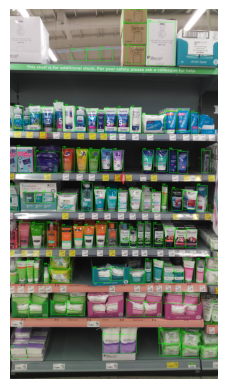

In [ ]:
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(img, outputs, threshold=0.5):
    """
    Visualize the predicted bounding boxes and scores on the image.
    Args:
        img: The input image tensor (C x H x W).
        outputs: The model predictions containing boxes, scores, etc.
        threshold: Minimum confidence score for displaying predictions.
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array
    img = (img * 255).astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for box, score in zip(outputs['boxes'], outputs['scores']):
        if score > threshold:  # Filter predictions by confidence
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage with previously computed predictions
# Assuming `imgs[0]` is the input image tensor and `outputs[0]` contains predictions
visualize_predictions(imgs[0], outputs[0])


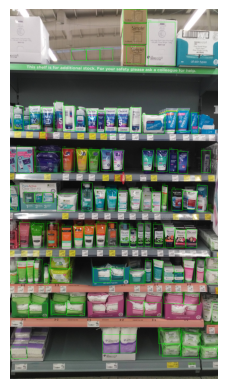

In [ ]:
def visualize_predictions(img, outputs, threshold=0.3):
    # Convert tensor to numpy array and scale back to image format
    img = img.permute(1, 2, 0).cpu().numpy()  # Channels Last
    img = (img * 255).astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Iterate over the predictions
    for box, score in zip(outputs['boxes'], outputs['scores']):
        if score > threshold:  # Only visualize boxes above the threshold
            x1, y1, x2, y2 = map(int, box.tolist())  # Convert box coordinates to integers
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw box
            cv2.putText(img, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  # Add score

    # Show the image with matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
visualize_predictions(imgs[0], outputs[0], threshold=0.3)


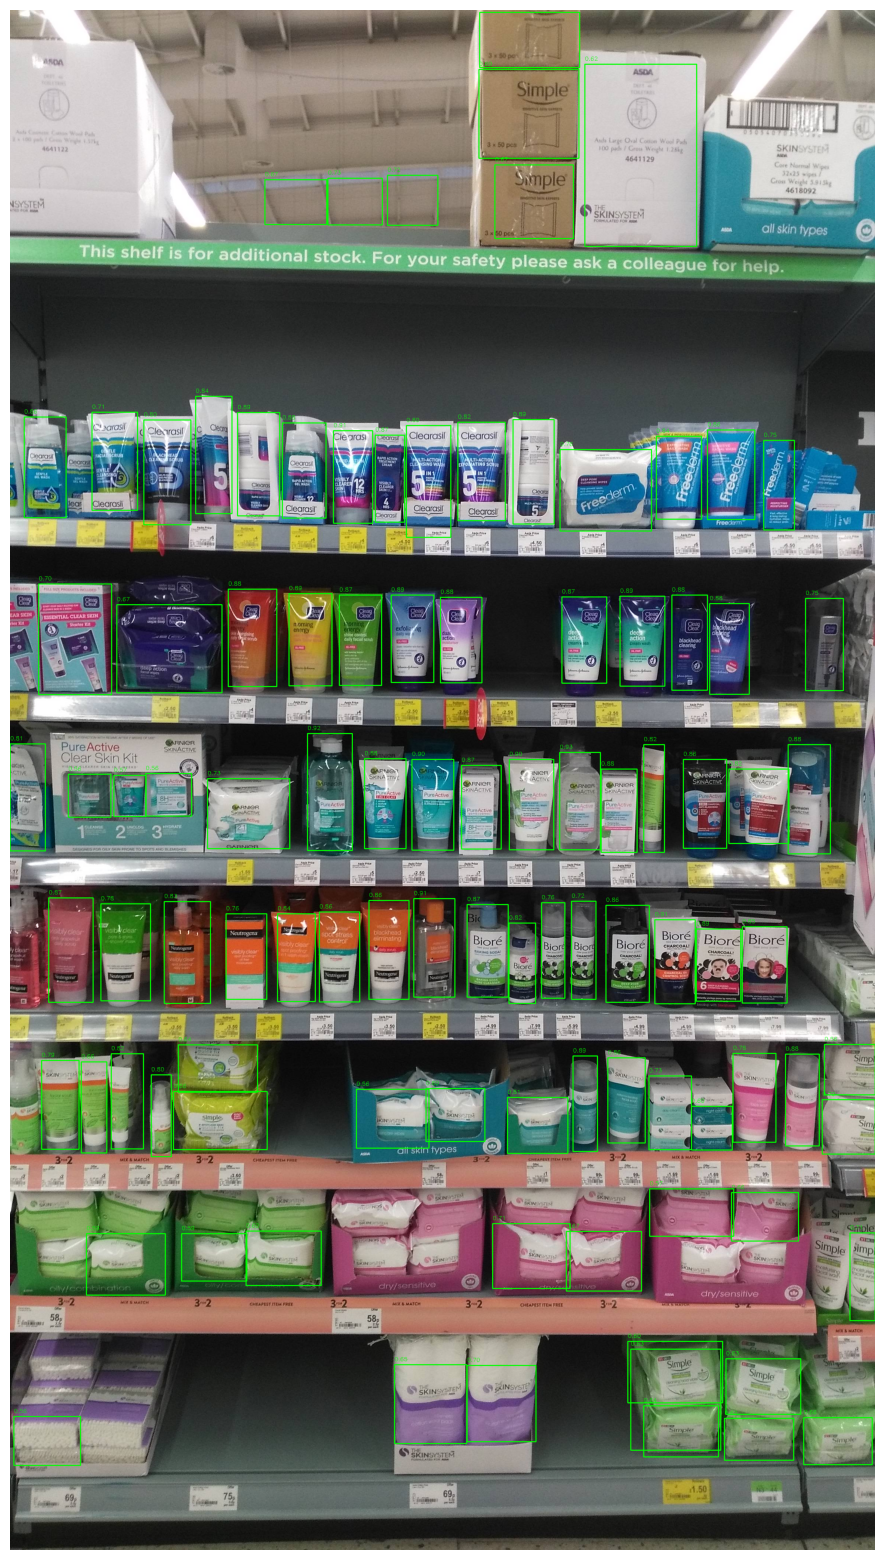

In [ ]:
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(img, outputs, threshold=0.3, figsize=(15, 15)):
    """
    Visualizes predictions on the given image with bounding boxes and confidence scores.

    Parameters:
    - img: Tensor representing the image (C, H, W).
    - outputs: Model outputs containing 'boxes' and 'scores'.
    - threshold: Minimum confidence score for displaying predictions.
    - figsize: Tuple specifying the size of the output figure (width, height).
    """
    try:
        # Convert tensor to numpy array and scale back to image format
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to Channels Last format
        img = (img * 255).astype("uint8")  # Scale image to 0-255
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

        # Draw predictions on the image
        for box, score in zip(outputs['boxes'], outputs['scores']):
            if score > threshold:  # Only visualize boxes above the threshold
                x1, y1, x2, y2 = map(int, box.tolist())  # Convert box coordinates to integers
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box
                cv2.putText(img, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0, 255, 0), 1)  # Add confidence score as text

        # Display the image using matplotlib with the specified figure size
        plt.figure(figsize=figsize)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error visualizing predictions: {e}")

# Example usage:
visualize_predictions(imgs[0], outputs[0], threshold=0.3, figsize=(20, 20))


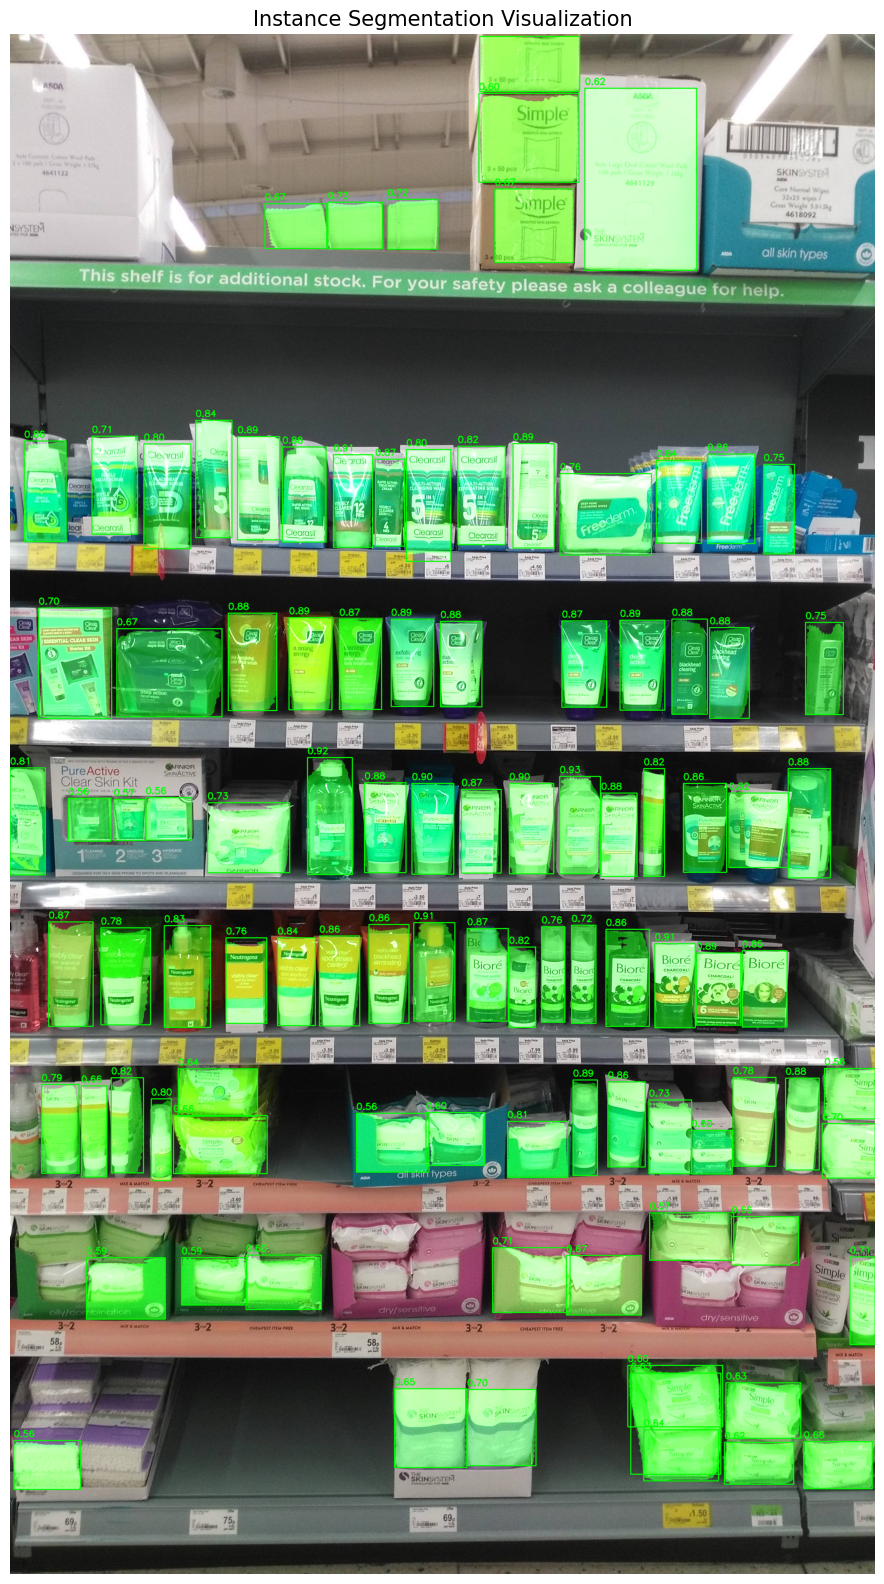

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_predictions_with_masks(img, outputs, threshold=0.3, alpha=0.5, figsize=(20, 20)):
    """
    Visualizes predictions by overlaying masks and bounding boxes on the image.

    Parameters:
    - img: The input image tensor (CHW format).
    - outputs: Model predictions containing 'boxes', 'scores', and 'masks'.
    - threshold: Confidence threshold for displaying detections.
    - alpha: Transparency factor for mask overlay.
    - figsize: Tuple specifying the figure size for display.
    """
    # Convert tensor to numpy array and scale back to image format
    img = img.permute(1, 2, 0).cpu().numpy()  # Channels Last
    img = (img * 255).astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Create a copy of the image for mask overlay
    img_with_masks = img.copy()

    # Iterate over the predictions
    for box, score, mask in zip(outputs['boxes'], outputs['scores'], outputs['masks']):
        if score > threshold:  # Only visualize detections above the threshold
            # Convert box coordinates to integers
            x1, y1, x2, y2 = map(int, box.tolist())

            # Apply the mask to the image
            mask = mask[0].cpu().numpy()  # Get the mask for the object
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))  # Resize mask to image dimensions
            mask = (mask > 0.5).astype(np.uint8)  # Binarize mask
            colored_mask = np.zeros_like(img)
            colored_mask[:, :, 1] = mask * 255  # Green mask

            # Overlay mask with transparency
            img_with_masks = cv2.addWeighted(img_with_masks, 1, colored_mask, alpha, 0)

            # Draw bounding box
            cv2.rectangle(img_with_masks, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_with_masks, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show the image with matplotlib
    plt.figure(figsize=figsize)  # Set figure size
    plt.imshow(cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Instance Segmentation Visualization", fontsize=15)
    plt.show()

# Visualize predictions with masks
visualize_predictions_with_masks(imgs[0], outputs[0], threshold=0.3)


In [ ]:
len(outputs)

1